In [1]:
from pathlib import Path

import matplotlib
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.text as mtext
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
DATA_ROOT = Path('..') / 'data'

In [3]:
dfs = []
activities = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in Path(DATA_ROOT).rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activities[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    dfs.append(df)

activity_df = pd.concat(dfs, axis='index')
activity_df.to_csv('activity_df.csv')

In [4]:
def get_activity_times(df):
    # Sort by time just in case...
    df = df.sort_values(by=['time'])
    
    # Neat trick!
    #    s = pd.Series([1,1,2,2,1,1,3])
    #    list((s.shift() != s).cumsum()) # <- [1, 1, 2, 2, 3, 3, 4] 
    groups = (df['activity'].shift() != df['activity']).cumsum()
    bounds = []
    for group, group_df in df.groupby(groups):
        first = group_df.iloc[0]
        last = group_df.iloc[-1]
        bounds.append({
            'activity': first['activity'], 
            'activity_label': first['activity_label'], 
            'start_index': first.index[0], 
            'end_index': last.index[0],
            'start_time': first['time'],
            'end_time': last['time'],
            'duration': last['time'] - first['time']
        })
    return pd.DataFrame(bounds)

In [5]:
def get_participant_activity_times(df):
    times_df = get_activity_times(df)
    times_df['participant'] = df['participant']
    return times_df

activity_times_df = activity_df.groupby(
    ['participant']).apply(get_participant_activity_times).reset_index(drop=True)

In [6]:
activity_times_df.head()

,activity,activity_label,start_index,end_index,start_time,end_time,duration,participant
0,1,bed,time,time,0.00,37.00,37.00,d1p01M
1,3,lying,time,time,37.75,74.25,36.50,d1p01M
2,1,bed,time,time,76.00,103.25,27.25,d1p01M
3,4,ambulating,time,time,104.00,111.50,7.50,d1p01M
4,2,chair,time,time,116.00,193.00,77.00,d1p01M


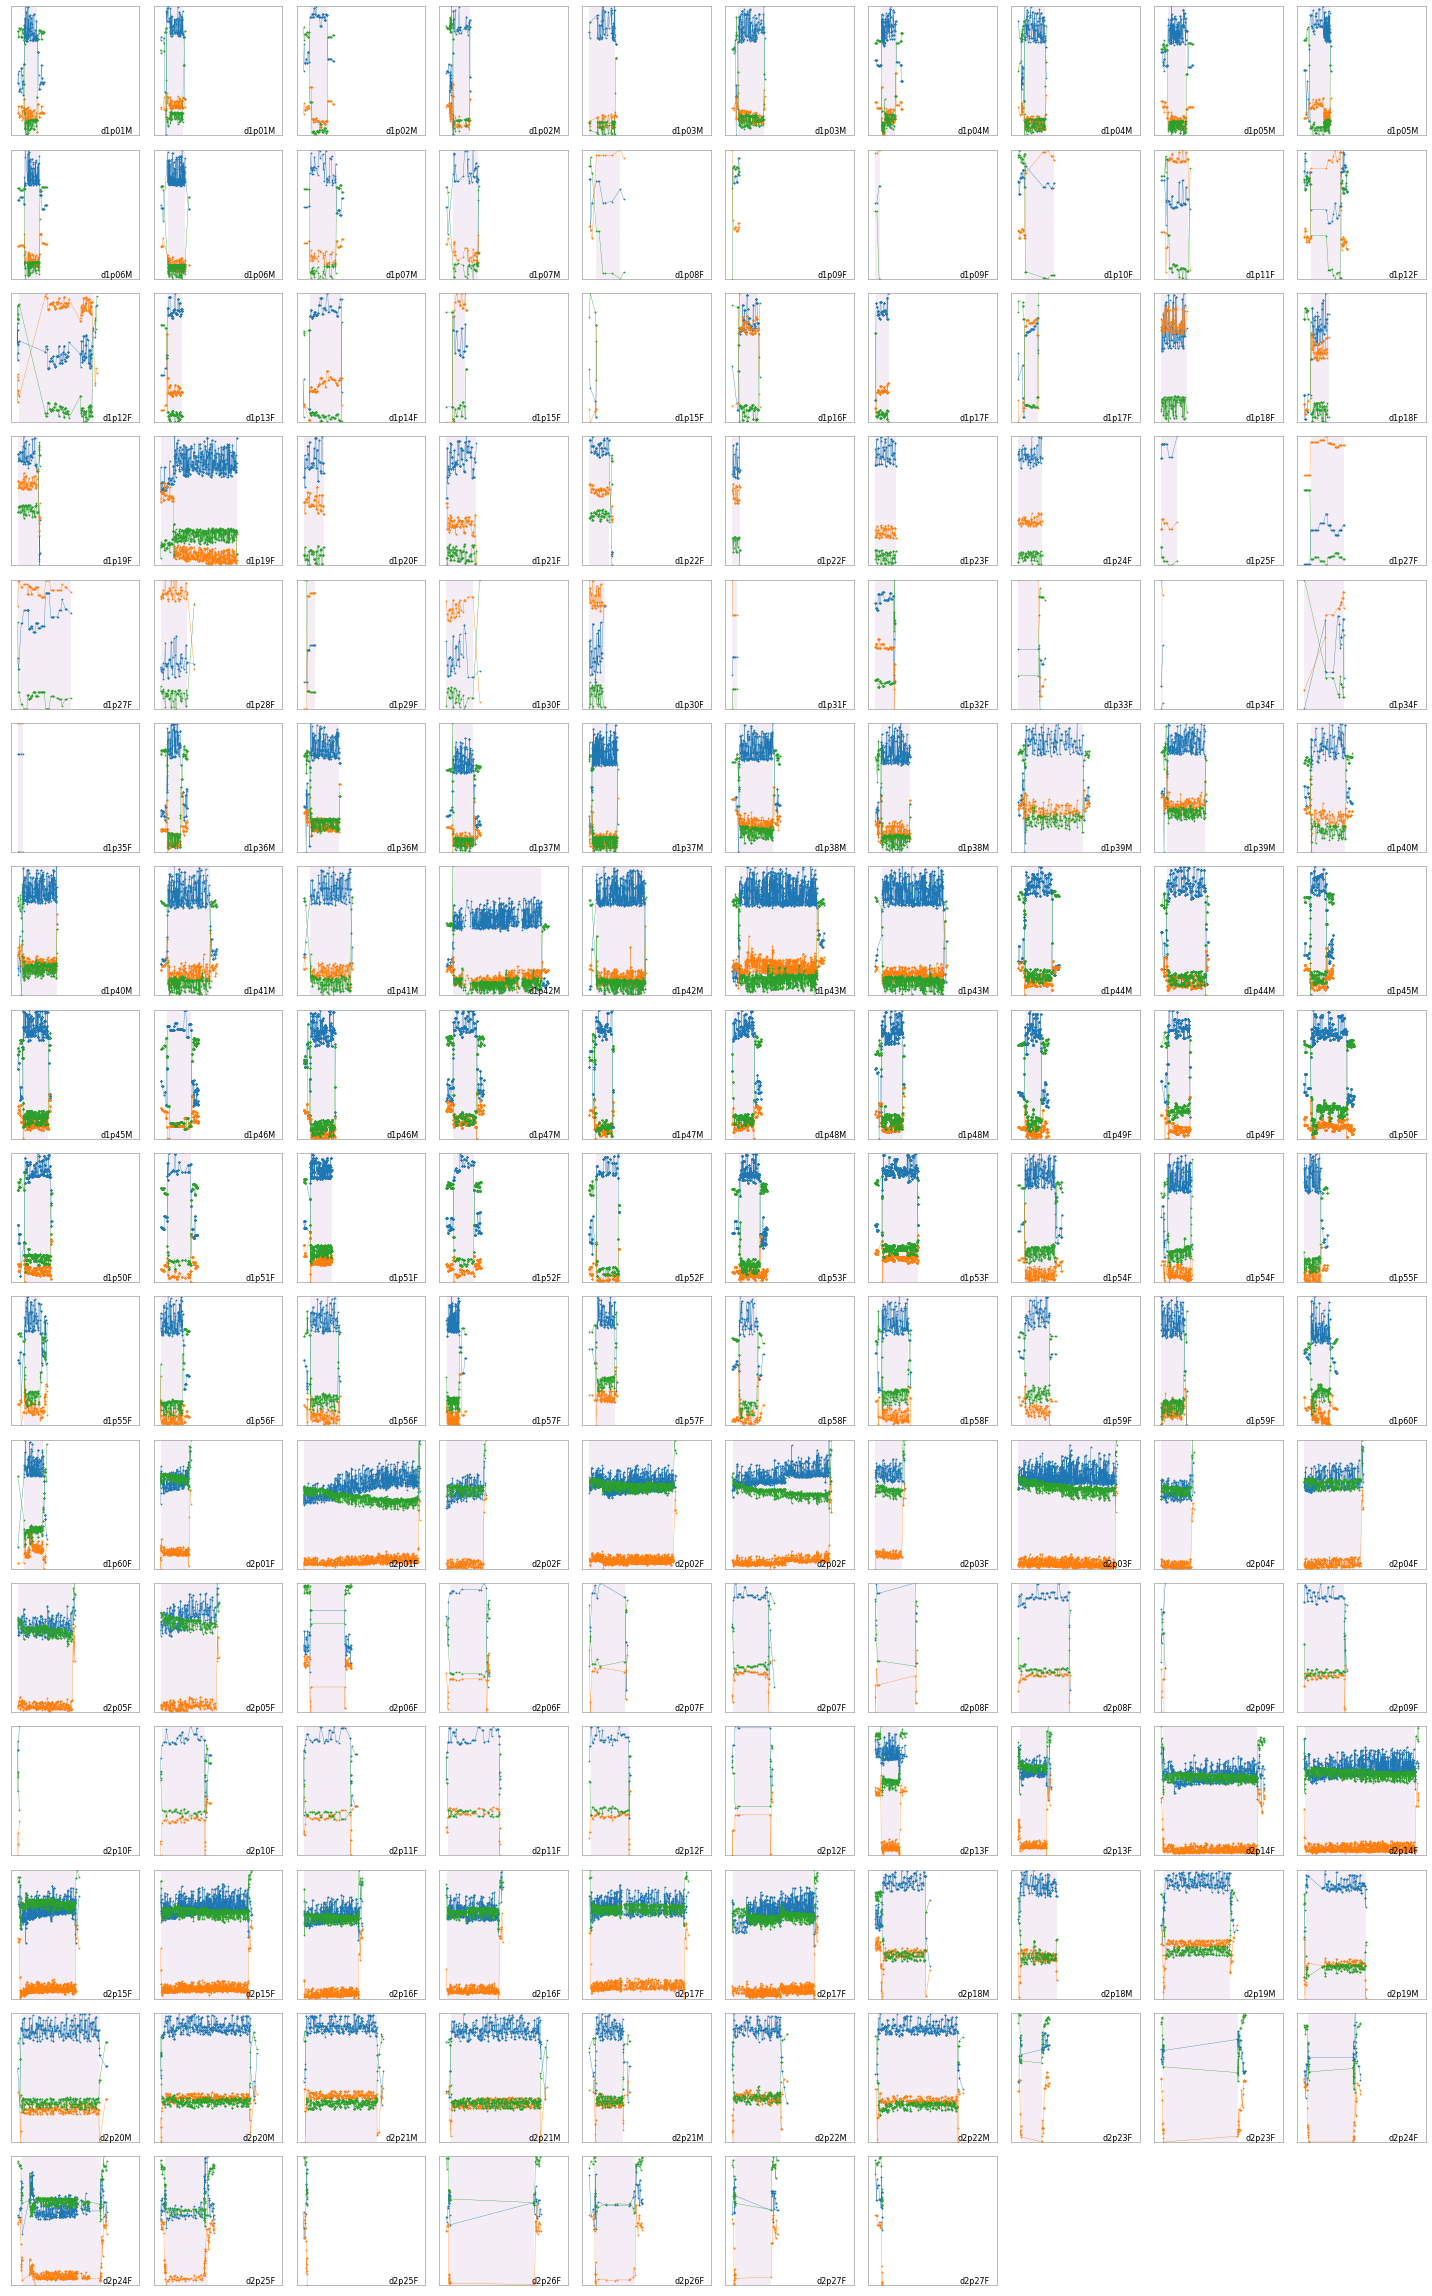

In [7]:
matplotlib.rc('axes', edgecolor='#aaaaaa')

# Rectangle colors
rect_colors = get_cmap('Pastel1').colors

# Line colors
line_colors = get_cmap('tab10').colors

# Common line options
line_opts = dict(linewidth=0.333, marker='.', markersize=1.5)

columns = ['front', 'lateral', 'vertical']
offset = 20

window_df = activity_times_df[activity_times_df['activity_label'] == 'lying'].reset_index(drop=True)
max_duration = window_df['duration'].max()

# define number of plots per row
ncols = 10
nrows = np.ceil(len(window_df) / ncols).astype(int)

# Create figure
fig = plt.figure(figsize=(ncols * 2, nrows * 2))

for index, row in window_df.iterrows():
    
    ax = plt.subplot(nrows, ncols, index + 1)
    # Tidy the axis up a bit
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0, 0, tight=True)
    ax.set_xlim((-offset, max_duration + offset))
    plot_df = activity_df[
        (activity_df['participant'] == row['participant']) &
        (activity_df['time'] >= row['start_time'] - offset) & 
        (activity_df['time'] <= row['end_time'] + offset)]
    
    ymin, ymax = plot_df[columns].min().min(), plot_df[columns].max().max()
    for j, column in enumerate(columns):
        t = plot_df['time'] - plot_df['time'].min()
        ax.plot(t, plot_df[column], color=line_colors[j], **line_opts)
    
    x = row['start_time'] - plot_df['time'].min()
    y = ymin
    height = ymax - ymin
    duration = row['duration']
    rect = mpatches.Rectangle(
        [x, y], 
        duration, 
        height, 
        alpha=0.333, 
        color=rect_colors[row['activity']], 
        linewidth=0, 
        zorder=1)
    ax.add_patch(rect)
            
    ax.text(
        max_duration, 
        plot_df[columns].min().min(), 
        row['participant'],
        fontsize=8, 
        ha='right', 
        va='bottom')

fig.patch.set_facecolor('#fff')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('lying.png')